In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas_ta as ta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import warnings
import quantstats as qs
warnings.filterwarnings("ignore")


In [2]:
son=pd.read_excel("./excel/FiyatPenceresi.Xlsx")
son=son[["Kod","Son.Fyt","Hcm","Yks","Dşk"]]
son.columns=["Hisse","Adj Close","Volume","High","Low"]
son=son.iloc[:-1,:]
son=son.dropna()


In [3]:
hisseler=son["Hisse"].values
hisseler=np.array(hisseler)

In [4]:
directory = 'C:/DATA'
import os
# Boş bir DataFrame oluştur
combined_df = pd.DataFrame()

# Dizindeki tüm JSON dosyalarını oku ve DataFrame'e ekle
for filename in os.listdir(directory):
    if filename.endswith('.json'):
        file_path = os.path.join(directory, filename)
        try:
            df = pd.read_json(file_path)
            combined_df = pd.concat([combined_df, df], ignore_index=True)
        except ValueError as e:
            print(f"Error reading {file_path}: {e}")

In [5]:
combined_df["PriceChannel"]=combined_df["PriceChannel"].str[12:].str.upper()
combined_df["Volume"]=combined_df["Amount"]*combined_df["Close"]
combined_df=combined_df.set_index(pd.to_datetime(combined_df["Date"]))
del combined_df["Date"]
del combined_df["Amount"]
combined_df=combined_df[["High","Low","Open","Close","Volume","PriceChannel"]]
combined_df.columns=['High', 'Low', 'Open', 'Adj Close', 'Volume', 'Hisse']
combined_df=combined_df[combined_df["Hisse"].isin(hisseler)]
combined_df = combined_df[~combined_df['Hisse'].isin(['IDEAS', 'ISATR', 'ISKUR', 'ITTFH'])]


In [6]:
combined_df=combined_df.groupby('Hisse').apply(lambda x: x.sort_index(ascending=True))

In [7]:
combined_df=combined_df.droplevel(level=0)

In [8]:
combined_df=combined_df.groupby('Hisse').apply(lambda x: x.sort_index(ascending=True)).droplevel(level=0)

In [9]:
combined_df["Kademe"] = np.where(combined_df["Adj Close"] < 20, 0.01,
                np.where(combined_df["Adj Close"] < 50, 0.02,
                    np.where(combined_df["Adj Close"] < 100, 0.05,
                        np.where(combined_df["Adj Close"] < 250, 0.1,
                            np.where(combined_df["Adj Close"] < 500, 0.25,
                                np.where(combined_df["Adj Close"] < 1000, 0.5,
                                    np.where(combined_df["Adj Close"] < 2500, 1, 2.5)
                                )  # Buradaki parantez eksikti.
                            )
                        )
                    )
                )
            )

In [10]:
combined_df["Tavan"]=((((combined_df["Adj Close"].shift(1))*1.1)/combined_df["Kademe"]).fillna(0).astype(int))*combined_df["Kademe"]
combined_df["Tavan"]=np.round(combined_df["Tavan"],2)

In [11]:
combined_df["Taban"]=((((combined_df["Adj Close"].shift(1))*0.9)//combined_df["Kademe"]).fillna(0).astype(int))*combined_df["Kademe"]
combined_df["Taban"]=np.round(combined_df["Taban"],2)
combined_df["Taban"]=combined_df["Taban"]+combined_df["Kademe"]
combined_df["Taban"]=np.round(combined_df["Taban"],2)

In [12]:
combined_df["Tavan Kontrol"]=np.where((combined_df["Tavan"]==combined_df["Adj Close"]),1,0)
combined_df["Taban Kontrol"]=np.where((combined_df["Taban"]==combined_df["Adj Close"]),1,0)

In [13]:
import pandas_ta as ta

combined_df["SMA 5"]=combined_df["Adj Close"].rolling(5).mean()
combined_df["SMA 10"]=combined_df["Adj Close"].rolling(5).mean()
combined_df["SMA 200"]=combined_df["Adj Close"].rolling(5).mean()

# RSI
combined_df["RSI"] = ta.rsi(combined_df["Adj Close"],14)

# Bağıl Hacim
combined_df["Bağıl Hacim"] = combined_df["Volume"] / combined_df["Volume"].rolling(10).mean()



# ADX, DMI, Aroon
adx_data = ta.adx(combined_df["High"], combined_df["Low"], combined_df["Adj Close"], 14)
combined_df["ADX"], combined_df["DMIP"], combined_df["DMIN"] = adx_data.iloc[:, 0], adx_data.iloc[:, 1], adx_data.iloc[:, 2]




def calculate_stoch_rsi(data, rsi_period=14, stochastic_period=14, k_period=3, d_period=3):
    rsi = ta.rsi(data["Adj Close"], rsi_period)
    stoch_rsi = (rsi - rsi.rolling(window=stochastic_period).min()) / (rsi.rolling(window=stochastic_period).max() - rsi.rolling(window=stochastic_period).min())
    stoch_rsi_k = stoch_rsi.rolling(window=k_period).mean() * 100
    stoch_rsi_d = stoch_rsi_k.rolling(window=d_period).mean()
    data['StochRSI_%K'] = stoch_rsi_k
    data['StochRSI_%D'] = stoch_rsi_d
    return data

combined_df = calculate_stoch_rsi(combined_df)


def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    data['EMA_12'] = ta.ema(data['Adj Close'], short_period)
    data['EMA_26'] = ta.ema(data['Adj Close'], long_period)
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal_Line'] = ta.ema(data['MACD'], signal_period)
    data['MACD_above_Signal'] = (data['MACD'] > data['Signal_Line']).astype(float)
    return data

combined_df = calculate_macd(combined_df)



# Diğer Göstergeler
combined_df["DD"] = ((combined_df["Adj Close"] / combined_df["High"]) - 1) * 100
combined_df["Range"] = ((combined_df["High"] - combined_df["Low"]) / combined_df["Adj Close"]) * 100

combined_df["MOM"] = ta.mom(combined_df["Adj Close"], 10)



combined_df["Driehaus Momentum"] = ((combined_df["Bağıl Hacim"] > 2) & (combined_df["RSI"] > 50) & (combined_df["MOM"] > 1) & (combined_df["Adj Close"] > combined_df["SMA 5"]) & (combined_df["Adj Close"] > combined_df["SMA 10"]) & (combined_df["Adj Close"] > combined_df["SMA 200"])).astype(int)
combined_df["MACD Yukarı Kesen"] = ((combined_df["Bağıl Hacim"] > 1.5) & (combined_df["MACD"] > 0) & (combined_df["MACD_above_Signal"] == 1)).astype(int)
combined_df["ADXDMI20"] = ((combined_df["Bağıl Hacim"] > 1.3) & (combined_df["ADX"] > 20) & (combined_df["DMIP"] > combined_df["DMIN"])).astype(int)
combined_df["MACD+Stoch"] = ((combined_df["Bağıl Hacim"] > 1.3) & (combined_df["StochRSI_%K"] > combined_df["StochRSI_%D"]) & (combined_df["MACD_above_Signal"] == 1)).astype(int)




In [14]:
import pandas_ta as ta
import ta as ta1

combined_df['MACD_Signal'] = combined_df["Signal_Line"]
combined_df['MACD_Diff'] = ta1.trend.macd_diff(combined_df['Adj Close'])
combined_df['ROC'] = ta.roc(combined_df["Adj Close"],12)



In [15]:
combined_df["Return"]=100*((combined_df["Open"]/combined_df["Adj Close"].shift(2))-1)
combined_df["Return"]=combined_df["Return"].shift(-2)
combined_df["Date"]=pd.to_datetime(combined_df.index)

combined_df


,High,Low,Open,Adj Close,Volume,Hisse,Kademe,Tavan,Taban,Tavan Kontrol,...,MOM,Driehaus Momentum,MACD Yukarı Kesen,ADXDMI20,MACD+Stoch,MACD_Signal,MACD_Diff,ROC,Return,Date
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-15,27.50,27.50,27.50,27.50,7.200518e+06,A1CAP,0.02,0.00,0.02,0,...,NaN,0,0,0,0,NaN,NaN,NaN,20.945455,2023-06-15
2023-06-16,30.24,30.24,30.24,30.24,3.531563e+07,A1CAP,0.02,30.24,24.76,1,...,NaN,0,0,0,0,NaN,NaN,NaN,2.513228,2023-06-16
2023-06-19,33.26,33.26,33.26,33.26,6.191715e+07,A1CAP,0.02,33.26,27.22,1,...,NaN,0,0,0,0,NaN,NaN,NaN,-18.941672,2023-06-19
2023-06-20,31.10,29.94,31.00,29.94,2.402000e+08,A1CAP,0.02,36.58,29.94,0,...,NaN,0,0,0,0,NaN,NaN,NaN,-14.428858,2023-06-20
2023-06-21,26.96,26.96,26.96,26.96,5.779965e+07,A1CAP,0.02,32.92,26.96,0,...,NaN,0,0,0,0,NaN,NaN,NaN,-3.041543,2023-06-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,7.71,7.44,7.56,7.52,3.516087e+07,ZRGYO,0.01,8.27,6.77,0,...,-0.64,0,0,0,0,0.124551,-0.045579,1.759134,1.196809,2024-06-14
2024-06-20,7.73,7.42,7.50,7.62,1.793442e+07,ZRGYO,0.01,8.27,6.77,0,...,-0.34,0,0,0,0,0.116358,-0.032776,-3.422053,5.905512,2024-06-20
2024-06-21,8.02,7.59,7.61,8.02,1.542262e+07,ZRGYO,0.01,8.38,6.86,0,...,0.07,0,0,0,0,0.116716,0.001433,-1.715686,1.246883,2024-06-21


In [47]:
endeks=pd.read_excel("./excel/xu100.xlsx")
endeks=endeks.set_index(pd.to_datetime(endeks["Tarih"],format="%d.%m.%Y"))
endeks=endeks["Kapanış"]
endeks=endeks.str.replace(",",".")
endeks=endeks.astype(float)
endeks=endeks.dropna()
endeks

Tarih
1995-01-02        2.51
1995-01-03        2.61
1995-01-04        2.64
1995-01-05        2.72
1995-01-06        2.69
                ...   
2024-06-14    10471.32
2024-06-20    10739.94
2024-06-21    10771.36
2024-06-24    10767.85
2024-06-25    10679.98
Name: Kapanış, Length: 7289, dtype: float64

In [17]:

combined_df["Endeks"]=endeks
combined_df["Endeks Return"]=100*((combined_df["Endeks"]/combined_df["Endeks"].shift(1))-1)
combined_df["Endeks Return Lag"]=100*((combined_df["Endeks"].shift(1)/combined_df["Endeks"].shift(2))-1)
combined_df["Return Lag"]=((combined_df["Adj Close"]/combined_df["Adj Close"].shift(1))-1)*100
combined_df

,High,Low,Open,Adj Close,Volume,Hisse,Kademe,Tavan,Taban,Tavan Kontrol,...,MACD+Stoch,MACD_Signal,MACD_Diff,ROC,Return,Date,Endeks,Endeks Return,Endeks Return Lag,Return Lag
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-15,27.50,27.50,27.50,27.50,7.200518e+06,A1CAP,0.02,0.00,0.02,0,...,0,NaN,NaN,NaN,20.945455,2023-06-15,5495.48,NaN,NaN,NaN
2023-06-16,30.24,30.24,30.24,30.24,3.531563e+07,A1CAP,0.02,30.24,24.76,1,...,0,NaN,NaN,NaN,2.513228,2023-06-16,5475.48,-0.363935,NaN,9.963636
2023-06-19,33.26,33.26,33.26,33.26,6.191715e+07,A1CAP,0.02,33.26,27.22,1,...,0,NaN,NaN,NaN,-18.941672,2023-06-19,5269.31,-3.765332,-0.363935,9.986772
2023-06-20,31.10,29.94,31.00,29.94,2.402000e+08,A1CAP,0.02,36.58,29.94,0,...,0,NaN,NaN,NaN,-14.428858,2023-06-20,5251.61,-0.335907,-3.765332,-9.981960
2023-06-21,26.96,26.96,26.96,26.96,5.779965e+07,A1CAP,0.02,32.92,26.96,0,...,0,NaN,NaN,NaN,-3.041543,2023-06-21,5186.83,-1.233526,-0.335907,-9.953240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,7.71,7.44,7.56,7.52,3.516087e+07,ZRGYO,0.01,8.27,6.77,0,...,0,0.124551,-0.045579,1.759134,1.196809,2024-06-14,10471.32,0.764346,2.226841,0.000000
2024-06-20,7.73,7.42,7.50,7.62,1.793442e+07,ZRGYO,0.01,8.27,6.77,0,...,0,0.116358,-0.032776,-3.422053,5.905512,2024-06-20,10739.94,2.565293,0.764346,1.329787
2024-06-21,8.02,7.59,7.61,8.02,1.542262e+07,ZRGYO,0.01,8.38,6.86,0,...,0,0.116716,0.001433,-1.715686,1.246883,2024-06-21,10771.36,0.292553,2.565293,5.249344


In [18]:
combined_df=combined_df.dropna()

In [19]:
combined_df=combined_df.sort_index()

In [20]:
target_data = {
    "2024-02-13": "PATEK.IS",
    "2024-02-15": "BORSK.IS",
    "2024-02-22": "LMKDC.IS",
    "2024-02-29": "ALVES.IS",
    "2024-03-04": "ARTMS.IS",
    "2024-03-05": "MOGAN.IS",
    "2024-03-11": ["BARMA.IS", "INVES.IS", "EDATA.IS"],
    "2024-03-21": "ODINE.IS",
    "2024-04-26": "RGYAS.IS",
    "2024-05-02": ["OBAMS.IS", "ENTRA.IS"],
    "2024-05-09": "LILAK.IS",
    "2024-05-10": "KOTON.IS",
    "2024-05-16": "ALTNY.IS",
    "2024-05-17": "KOCMT.IS",
    "2024-05-23": "HRKET.IS",
    "2024-05-27": "PEHOL.IS",
    "2024-05-28": "ONRYT.IS",
    "2024-05-29": "OZYSR.IS",
    "2024-06-04": "ALKLC.IS",
    "2024-06-06": "YIGIT.IS",
    "2024-06-07": "HOROZ.IS"
}
for date, stocks in target_data.items():
    if isinstance(stocks, list):
        for stock in stocks:
            combined_df.loc[(combined_df.index == date) & (combined_df["Hisse"] == stock), "Tavan Kontrol"] = 1
    else:
        combined_df.loc[(combined_df.index == date) & (combined_df["Hisse"] == stocks), "Tavan Kontrol"] = 1
son=combined_df.loc[combined_df.sort_index().index.unique()[-2:]]
ilk=combined_df.loc[combined_df.sort_index().index.unique()[:-2]]
ilk=ilk[(ilk["Return"]<21) & (ilk["Return"]>-19)]
result=pd.concat([ilk,son],axis=0)

In [21]:


yasak=["YYAPI","EMNIS","TETMT","RODRG","BRKO","AYES","EUKYO","YGYO","BALAT","SONME","SNKRN","KSTUR","DERIM","UZERB","MARKA","MMCAS","YAYLA"]
for i in range(len(yasak)):
    yasak[i]=yasak[i]+".IS"

In [22]:
combined_df=combined_df.sort_index()

yasak=["YYAPI","EMNIS","TETMT","RODRG","BRKO","AYES","EUKYO","YGYO","BALAT","SONME","SNKRN","KSTUR","DERIM","UZERB","MARKA","MMCAS","YAYLA"]
result=result.dropna()
result = result[~result['Hisse'].isin(["ISATR","ISBTR"])]
result = result[~result['Hisse'].isin(yasak)]
result=result[result["Tavan Kontrol"]==0]
result=result.sort_index()


In [ ]:
mindates=combined_df.groupby("Hisse")["Date"].min()
arzlar=mindates[mindates>"2023-07-01"].index

In [ ]:
import optuna
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit




def objective(trial):
    # Hyperparameter space
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'random_strength': trial.suggest_int('random_strength', 1, 20),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 30)
    }

    model = CatBoostRegressor(**param, verbose=0, random_seed=42, task_type="GPU")



    model.fit(X_train, y_train)

        
    tahminler=pd.DataFrame(val["Return"])
    tahminler=tahminler.set_index(X_val.index)
    tahminler["Tahmin"]=model.predict(X_val)
    tahminler.columns=["Gerçek","Tahmin"]
    tahminler["Hisse"]=val["Hisse"]
    tahminler["Tavan"]=val["Tavan Kontrol"]
    tahminler["Taban"]=val["Taban Kontrol"]
    tahminler=tahminler[tahminler["Tavan"]==0]
    tahminler=tahminler[tahminler["Taban"]==0]
    tahminler = tahminler[~tahminler['Hisse'].isin(arzlar)]
    top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(3, columns=['Tahmin'])).dropna()
    topkar = (top_5_rows.groupby('Date')["Gerçek"].mean().cumsum()/2 )
    returns = (top_5_rows.groupby('Date')["Gerçek"].mean().cumsum()/2).diff().dropna()
    pozitif = returns[returns > 0].mean()
    negatif = returns[returns < 0].mean()
    ort = abs(pozitif / negatif)
    print(topkar.iloc[-1])
        

    
    return ort

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

print('En iyi parametreler: ', study.best_params)
print('En iyi skor: ', study.best_value)


In [ ]:
trials=study.trials_dataframe()

In [ ]:
aralık=range(0,20)
for trial in aralık:
        params = {'iterations': trials.sort_values(by="value",ascending=False)["params_iterations"].iloc[trial],
        'depth': trials.sort_values(by="value",ascending=False)["params_depth"].iloc[trial],
        'learning_rate': trials.sort_values(by="value",ascending=False)["params_learning_rate"].iloc[trial],
        'random_strength': trials.sort_values(by="value",ascending=False)["params_random_strength"].iloc[trial],
        'bagging_temperature': trials.sort_values(by="value",ascending=False)["params_bagging_temperature"].iloc[trial],
        'border_count': trials.sort_values(by="value",ascending=False)["params_border_count"].iloc[trial],
        'l2_leaf_reg': trials.sort_values(by="value",ascending=False)["params_l2_leaf_reg"].iloc[trial]}
        model=CatBoostRegressor(**params,task_type="GPU",random_seed=42,verbose=0)
        model.fit(X_train,y_train)
        tahminler=pd.DataFrame(test["Return"])
        tahminler=tahminler.set_index(X_test.index)
        tahminler["Tahmin"]=model.predict(X_test)
        tahminler.columns=["Gerçek","Tahmin"]
        tahminler["Hisse"]=test["Hisse"]
        tahminler["Tavan"]=test["Tavan Kontrol"]
        tahminler["Taban"]=test["Taban Kontrol"]
        tahminler=tahminler[tahminler["Tavan"]==0]
        tahminler=tahminler[tahminler["Taban"]==0]
        tahminler = tahminler[~tahminler['Hisse'].isin(arzlar)]
        top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(3, columns=['Tahmin'])).dropna()
        topkar=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2)
        returns=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2).diff().dropna()
        pozitif=returns[returns>0].mean()
        negatif=returns[returns<0].mean()
        ort=abs(pozitif/negatif)
        print("Trial:{} Top Kar:{} Ort Kar/Zarar:{}".format(trial,topkar.iloc[-1],ort))


Trial:0 Top Kar:111.7728715828385 Ort Kar/Zarar:1.7139856103985127
Trial:1 Top Kar:101.99460128871455 Ort Kar/Zarar:1.9406002842505112
Trial:2 Top Kar:133.5737778064694 Ort Kar/Zarar:1.8936084465047829
Trial:3 Top Kar:91.12248276951685 Ort Kar/Zarar:1.663926237755832
Trial:4 Top Kar:112.99414128613893 Ort Kar/Zarar:1.782735504083302
Trial:5 Top Kar:95.87059580778079 Ort Kar/Zarar:1.6060897348803884
Trial:6 Top Kar:94.67759907375071 Ort Kar/Zarar:1.8714159020982593
Trial:7 Top Kar:103.96393556465175 Ort Kar/Zarar:1.7617300210524436
Trial:8 Top Kar:88.24162663486939 Ort Kar/Zarar:1.8414133183155408
Trial:9 Top Kar:95.17781038725116 Ort Kar/Zarar:2.3403495091010766
Trial:10 Top Kar:109.34035328287746 Ort Kar/Zarar:1.1863300186047137
Trial:11 Top Kar:89.7959236770092 Ort Kar/Zarar:1.7235176947217614
Trial:12 Top Kar:86.58624537676843 Ort Kar/Zarar:1.5994981730827558
Trial:13 Top Kar:104.15861699671126 Ort Kar/Zarar:1.773191471810984
Trial:14 Top Kar:103.66323526462467 Ort Kar/Zarar:1.97425

In [23]:
val=result.loc["2023-07-01":"2023-12-31"].dropna()
train=result.loc["2017-01-01":"2023-06-30"].dropna()
test=result.loc["2024-01-01":].dropna()
X_train=train[['Endeks Return','Return Lag','Range','RSI','Volume','Bağıl Hacim','DD','High', 'Low', 'Open', 'Adj Close','StochRSI_%K','MACD','ROC','MACD_Signal','MOM']]
X_test=test[['Endeks Return','Return Lag','Range','RSI','Volume','Bağıl Hacim','DD','High', 'Low', 'Open', 'Adj Close','StochRSI_%K','MACD','ROC','MACD_Signal','MOM']]
X_val=val[['Endeks Return','Return Lag','Range','RSI','Volume','Bağıl Hacim','DD','High', 'Low', 'Open', 'Adj Close','StochRSI_%K','MACD','ROC','MACD_Signal','MOM']]
y_train=train["Return"]
y_test=test["Return"]
y_val=val["Return"]

In [ ]:
params = {'iterations': 406,
 'depth': 8,
 'learning_rate': 0.05908481614373525,
 'random_strength': 15,
 'bagging_temperature': 0.48897432777080385,
 'border_count': 163,
 'l2_leaf_reg': 9}
model=CatBoostRegressor(**params,task_type="GPU",random_seed=42)
model.load_model("./model/xtumyson.bin")

In [24]:
model=CatBoostRegressor(task_type="GPU",random_seed=42)
model.load_model("./model/xtumyyeni.bin")

In [25]:
mindates=combined_df.groupby("Hisse")["Date"].min()
arzlar=mindates[mindates>"2024-01-01"].index

In [26]:
tahminler=pd.DataFrame(test["Return"])
tahminler=tahminler.set_index(X_test.index)
tahminler["Tahmin"]=model.predict(X_test)
tahminler.columns=["Gerçek","Tahmin"]
tahminler["Hisse"]=test["Hisse"]
tahminler["Tavan"]=test["Tavan Kontrol"]
tahminler["Taban"]=test["Taban Kontrol"]
tahminler=tahminler[tahminler["Tavan"]==0]
tahminler=tahminler[tahminler["Taban"]==0]
tahminler = tahminler[~tahminler['Hisse'].isin(arzlar)]
top_5_rows = tahminler.groupby(level=0).apply(lambda x: x.nlargest(4, columns=['Tahmin'])).dropna()
topkar=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2)
returns=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2).diff().dropna()
pozitif=returns[returns>0].mean()
negatif=returns[returns<0].mean()
ort=abs(pozitif/negatif)
ort

1.9407191806969024

In [27]:
topkar

Date
2024-01-02      0.155873
2024-01-03      0.464937
2024-01-04      2.026057
2024-01-05      3.652088
2024-01-08      3.564177
                 ...    
2024-06-12    116.465119
2024-06-13    117.237090
2024-06-14    119.512483
2024-06-20    121.987075
2024-06-21    120.003129
Name: Gerçek, Length: 113, dtype: float64

In [28]:
top_5_rows1=top_5_rows.copy()
komisyon=top_5_rows["Gerçek"]*0.04
borsapayı=top_5_rows["Gerçek"]*2.5/100000
bsmv=komisyon*0.05
kesinti=2*(komisyon+borsapayı+bsmv)
top_5_rows1["Gerçek"]=top_5_rows["Gerçek"]-kesinti


In [51]:
top_5_rows2=top_5_rows.copy()
komisyon=top_5_rows["Gerçek"]*0.2
borsapayı=top_5_rows["Gerçek"]*2.5/100000
bsmv=komisyon*0.05
kesinti=2*(komisyon+borsapayı+bsmv)
top_5_rows2["Gerçek"]=top_5_rows["Gerçek"]-kesinti

In [29]:
top_5_rows1.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum()/2

Date
2024-01-02      0.142772
2024-01-03      0.425859
2024-01-04      1.855767
2024-01-05      3.345130
2024-01-08      3.264608
                 ...    
2024-06-12    106.676226
2024-06-13    107.383312
2024-06-14    109.467458
2024-06-20    111.734061
2024-06-21    109.916866
Name: Gerçek, Length: 113, dtype: float64

In [30]:
kar=(((np.cumprod(1+((top_5_rows1.groupby('Date')["Gerçek"].mean().iloc[:-2]/2)/100)))-1)*100).iloc[-1]
returns=(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2]/2).diff().dropna()

sharpe=kar/returns.std()
sharpe

85.63710809367196

In [31]:
top_5_rows=top_5_rows.droplevel(level=0)
top_5_rows1=top_5_rows1.droplevel(level=0)


In [48]:
endeks=pd.DataFrame(endeks)
endeks=endeks.loc["2024-01-01":]
endeks["Getiri"]=0
for i in range(1,len(endeks)):
    endeks["Getiri"].iloc[i]=endeks["Kapanış"].iloc[i]/endeks["Kapanış"].iloc[0]
endeks["Getiri"]=100*(endeks["Getiri"]-1)
endeks["Getiri"].iloc[0]=0
endeks

,Kapanış,Getiri
Tarih,,
2024-01-02,7624.29,0.000000
2024-01-03,7412.04,-2.783866
2024-01-04,7547.84,-1.002716
2024-01-05,7628.73,0.058235
2024-01-08,7818.89,2.552369
...,...,...
2024-06-14,10471.32,37.341575
2024-06-20,10739.94,40.864789
2024-06-21,10771.36,41.276893


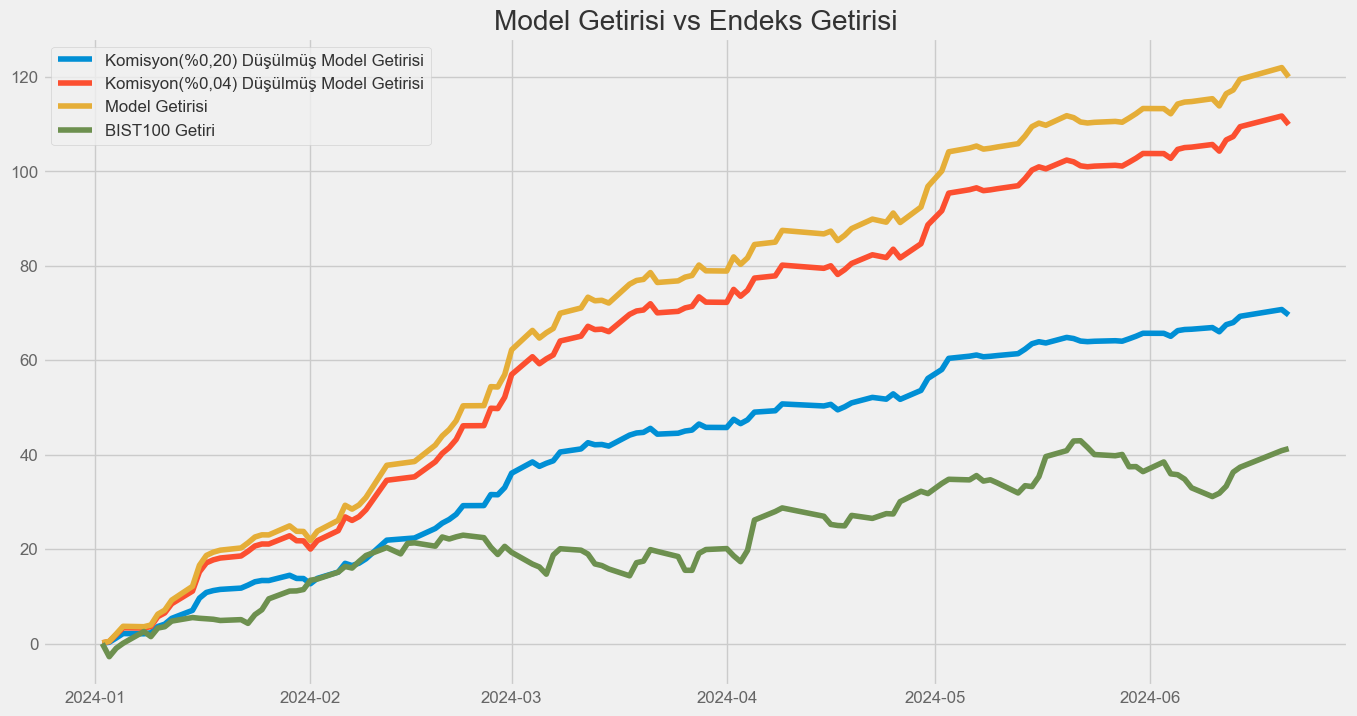

In [54]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,8))
plt.title("Model Getirisi vs Endeks Getirisi")
plt.plot(top_5_rows2.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum().dropna()/2,label="Komisyon(%0,20) Düşülmüş Model Getirisi")
plt.plot(top_5_rows1.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum().dropna()/2,label="Komisyon(%0,04) Düşülmüş Model Getirisi")
plt.plot(top_5_rows.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum().dropna()/2,label="Model Getirisi")
plt.plot(endeks["Getiri"].loc[:"2024-06-23"],label="BIST100 Getiri")
legend_properties = {'fontweight':'bold'}
plt.legend()

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, 'IZFAS'),
  Text(0, 1, 'VESTL'),
  Text(0, 2, 'AVPGY'),
  Text(0, 3, 'BANVT'),
  Text(0, 4, 'AGROT'),
  Text(0, 5, 'ATEKS'),
  Text(0, 6, 'KUTPO'),
  Text(0, 7, 'MARBL'),
  Text(0, 8, 'MEGMT'),
  Text(0, 9, 'LKMNH'),
  Text(0, 10, 'BRYAT'),
  Text(0, 11, 'YUNSA'),
  Text(0, 12, 'KCHOL'),
  Text(0, 13, 'TRILC'),
  Text(0, 14, 'AKMGY'),
  Text(0, 15, 'CLEBI'),
  Text(0, 16, 'RAYSG'),
  Text(0, 17, 'SELGD'),
  Text(0, 18, 'PAPIL'),
  Text(0, 19, 'KTLEV'),
  Text(0, 20, 'BEGYO'),
  Text(0, 21, 'OSMEN'),
  Text(0, 22, 'ZEDUR'),
  Text(0, 23, 'EGPRO'),
  Text(0, 24, 'TSGYO'),
  Text(0, 25, 'TGSAS'),
  Text(0, 26, 'AZTEK'),
  Text(0, 27, 'JANTS'),
  Text(0, 28, 'SKYMD'),
  Text(0, 29, 'BRKVY')])

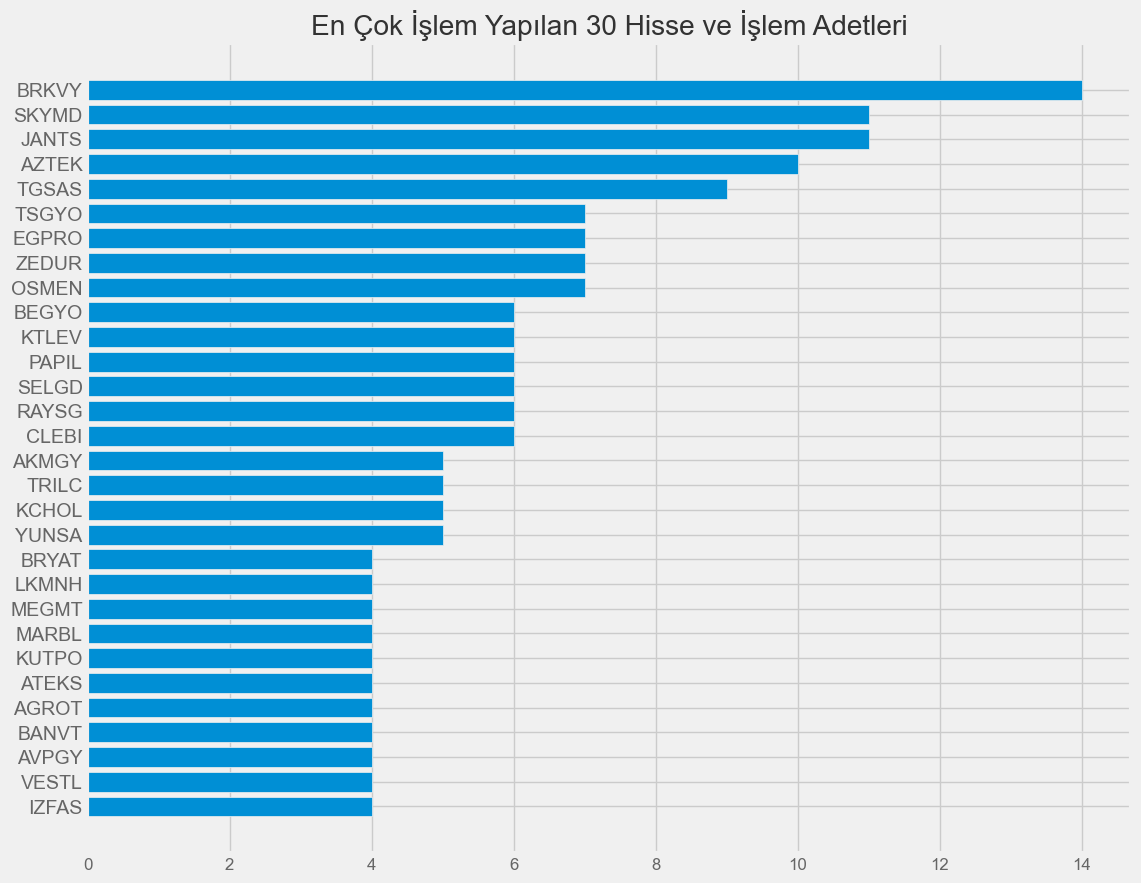

In [55]:
plt.figure(figsize=(12,10))
plt.title("En Çok İşlem Yapılan 30 Hisse ve İşlem Adetleri")
plt.barh(top_5_rows["Hisse"].value_counts().sort_values().tail(30).index,top_5_rows["Hisse"].value_counts().sort_values().tail(30).values)
plt.yticks(fontsize=13,fontweight="bold",font="Arial")

In [34]:

returns=top_5_rows1.groupby('Date')["Gerçek"].mean().iloc[:-2].cumsum().diff().dropna()/2
returns=returns/100
returns=pd.DataFrame(returns)
returns["Kar"]=np.where((returns>0),1,0)
returns
returns

,Gerçek,Kar
Date,,
2024-01-03,0.002831,1
2024-01-04,0.014299,1
2024-01-05,0.014894,1
2024-01-08,-0.000805,0
2024-01-09,0.003316,1
...,...,...
2024-06-12,0.023767,1
2024-06-13,0.007071,1
2024-06-14,0.020841,1


In [83]:
def ortalama_kazanma_serisi_uzunlugu(veri):
    kazanma_serileri = []  # Kazanma serilerini tutacak bir liste oluşturuyoruz.
    current_series_length = 0  # Şu anki kazanma serisinin uzunluğunu tutacak değişken
    for num in veri:
        if num == 1:  # Eğer 1 görürsek,
            current_series_length += 1  # Kazanma serisinin uzunluğunu bir arttır.
        else:
            if current_series_length > 0:  # Eğer kazanma serisi bitmişse,
                kazanma_serileri.append(current_series_length)  # Kazanma serisinin uzunluğunu listeye ekle.
                current_series_length = 0  # Şu anki kazanma serisi uzunluğunu sıfırla.
    if current_series_length > 0:  # Eğer döngü biterken hala bir kazanma serisi varsa,
        kazanma_serileri.append(current_series_length)  # Son kazanma serisini de listeye ekle.
    
    # Kazanma serilerinin ortalama uzunluğunu hesapla.
    ortalama_uzunluk = sum(kazanma_serileri) / len(kazanma_serileri)
    
    return ortalama_uzunluk



# Fonksiyonu çağırarak ortalama kazanma serisi uzunluğunu bul
ortalama = ortalama_kazanma_serisi_uzunlugu(list(endeks["Kar"].values))
print("Ortalama kazanma serisi uzunluğu:", ortalama)


Ortalama kazanma serisi uzunluğu: 2.48


In [87]:
def ortalama_kaybetme_serisi_uzunlugu(veri):
    kaybetme_serileri = []  # Kaybetme serilerini tutacak bir liste oluşturuyoruz.
    current_series_length = 0  # Şu anki kaybetme serisinin uzunluğunu tutacak değişken
    for num in veri:
        if num == 0:  # Eğer 0 görürsek,
            current_series_length += 1  # Kaybetme serisinin uzunluğunu bir arttır.
        else:
            if current_series_length > 0:  # Eğer kaybetme serisi bitmişse,
                kaybetme_serileri.append(current_series_length)  # Kaybetme serisinin uzunluğunu listeye ekle.
                current_series_length = 0  # Şu anki kaybetme serisi uzunluğunu sıfırla.
    if current_series_length > 0:  # Eğer döngü biterken hala bir kaybetme serisi varsa,
        kaybetme_serileri.append(current_series_length)  # Son kaybetme serisini de listeye ekle.
    
    # Kaybetme serilerinin ortalama uzunluğunu hesapla.
    ortalama_uzunluk = sum(kaybetme_serileri) / len(kaybetme_serileri)
    
    return ortalama_uzunluk



# Fonksiyonu çağırarak ortalama kaybetme serisi uzunluğunu bul
ortalama = ortalama_kaybetme_serisi_uzunlugu(list(returns["Kar"].values))
print("Ortalama kaybetme serisi uzunluğu:", ortalama)


Ortalama kaybetme serisi uzunluğu: 1.2727272727272727


In [79]:
endeks["Return"]=(endeks["Kapanış"]/endeks["Kapanış"].shift(1))-1
endeks

,Kapanış,Getiri,Return
Tarih,,,
2024-01-02,7624.29,0.000000,NaN
2024-01-03,7412.04,-2.783866,-0.027839
2024-01-04,7547.84,-1.002716,0.018322
2024-01-05,7628.73,0.058235,0.010717
2024-01-08,7818.89,2.552369,0.024927
...,...,...,...
2024-06-14,10471.32,37.341575,0.007643
2024-06-20,10739.94,40.864789,0.025653
2024-06-21,10771.36,41.276893,0.002926


In [80]:
endeks["Kar"]=np.where((endeks["Return"]>0),1,0)


In [39]:
qs.reports.html(returns=returns["Gerçek"],benchmark=endeks["Return"])

In [93]:
returns["Gerçek"].std()*100

1.5262317461609876

In [82]:
endeks

,Kapanış,Getiri,Return,Kar
Tarih,,,,
2024-01-02,7624.29,0.000000,NaN,0
2024-01-03,7412.04,-2.783866,-0.027839,0
2024-01-04,7547.84,-1.002716,0.018322,1
2024-01-05,7628.73,0.058235,0.010717,1
2024-01-08,7818.89,2.552369,0.024927,1
...,...,...,...,...
2024-06-14,10471.32,37.341575,0.007643,1
2024-06-20,10739.94,40.864789,0.025653,1
2024-06-21,10771.36,41.276893,0.002926,1


In [98]:
1+(topkar/100)

Date
2024-01-02    1.001559
2024-01-03    1.004649
2024-01-04    1.020261
2024-01-05    1.036521
2024-01-08    1.035642
                ...   
2024-06-12    2.164651
2024-06-13    2.172371
2024-06-14    2.195125
2024-06-20    2.219871
2024-06-21    2.200031
Name: Gerçek, Length: 113, dtype: float64

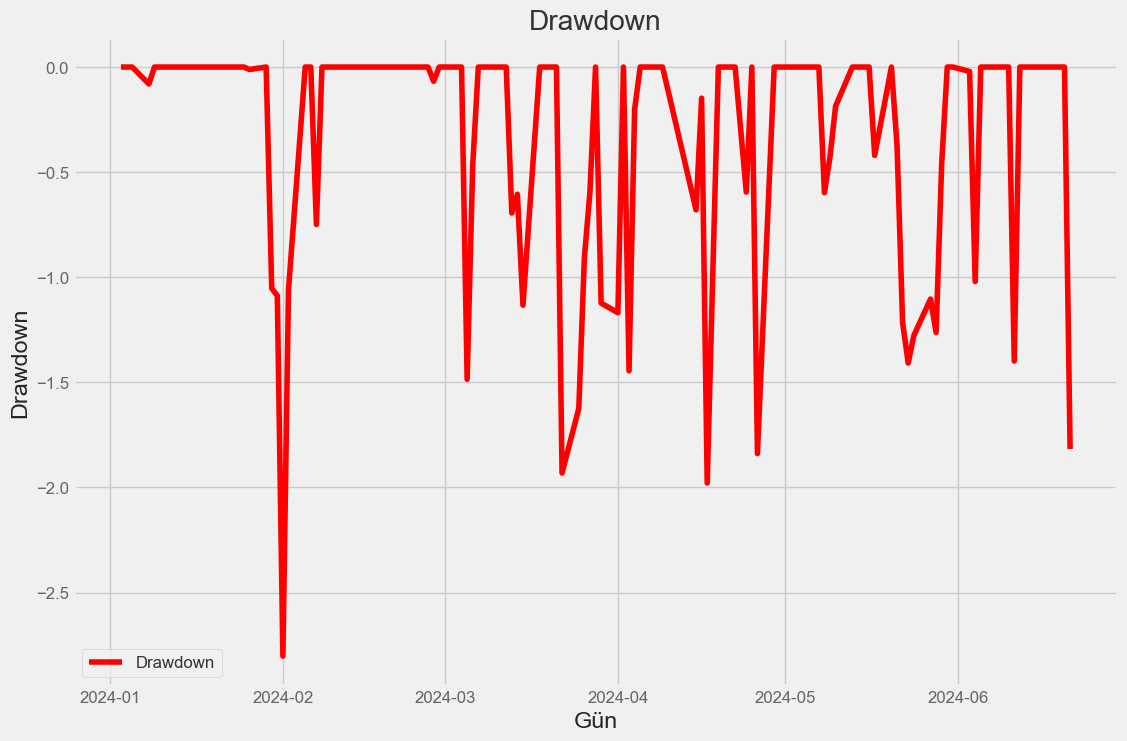

In [101]:
import pandas as pd
import matplotlib.pyplot as plt


# Convert to DataFrame
cumulative_returns = np.cumprod(1+returns["Gerçek"])


def calculate_drawdowns(returns):
    peak = returns[0]
    drawdowns = [0]  # İlk değer 0, çünkü başlangıçta herhangi bir drawdown yok

    for ret in returns[1:]:
        if ret > peak:
            peak = ret
            drawdowns.append(0)  # Yeni zirve bulunduğunda drawdown sıfırlanır
        else:
            drawdowns.append(-100*((peak - ret) / peak))  # Drawdown hesaplanır
    
    return drawdowns

# Drawdown'ları hesapla
drawdowns = calculate_drawdowns(cumulative_returns)


# Grafik çizimi
plt.figure(figsize=(12, 8))
plt.plot(returns.index, drawdowns, label='Drawdown', color='red', linestyle='-')
plt.xlabel('Gün')
plt.ylabel('Drawdown')
plt.title('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

In [102]:
top_5_rows["Para"]=1000
top_5_rows["Bakiye"]

,Gerçek,Tahmin,Hisse,Tavan,Taban,Para
Date,,,,,,
2024-01-02,2.349446,4.148378,MTRKS,0,0,1000
2024-01-02,3.628316,3.597859,AZTEK,0,0,1000
2024-01-02,-3.708134,3.036310,HUBVC,0,0,1000
2024-01-02,-1.022644,2.936274,SANEL,0,0,1000
2024-01-03,1.716738,2.969563,MAGEN,0,0,1000
...,...,...,...,...,...,...
2024-06-24,-94.478528,1.113583,BASGZ,0,0,1000
2024-06-25,-99.969093,2.208223,POLTK,0,0,1000
2024-06-25,-99.318294,1.101703,ISKPL,0,0,1000


In [ ]:
feature_importance = model.get_feature_importance(type='FeatureImportance')

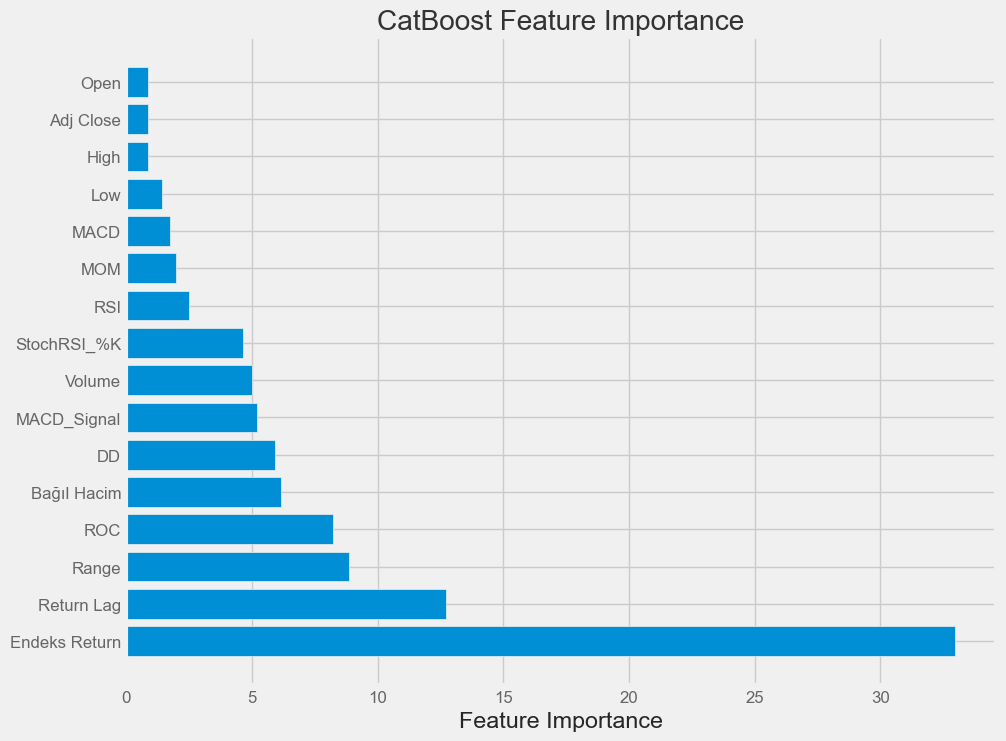

In [ ]:
import catboost
feature_importance = model.get_feature_importance(type='FeatureImportance')
# Özellik isimlerini alın
feature_names = model.feature_names_

# Özellik önemlerini bir sözlükte saklayın
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Özellik önemlerine göre sıralayın
sorted_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Görselleştirme
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importance)), [val[1] for val in sorted_importance], align='center')
plt.yticks(range(len(sorted_importance)), [val[0] for val in sorted_importance])
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()

In [ ]:
top_5_rows1["date"]=pd.to_datetime(top_5_rows1.index)

In [ ]:
satışlar = []
indexler = top_5_rows1['date'].unique()

for date in top_5_rows1['date']:
    future_dates = indexler[indexler > date]
    if len(future_dates) >= 2:
        satış_tarihi = future_dates[1]
    else:
        satış_tarihi = pd.NaT
    satışlar.append(satış_tarihi)

top_5_rows1['satış_tarihi'] = satışlar

In [ ]:
combined_df["date"]=pd.to_datetime(combined_df.index)

In [ ]:
top_5_rows1['Alış Fiyatı'] = top_5_rows1.set_index(['date', 'Hisse']).index.map(combined_df.set_index(['date', 'Hisse'])['Adj Close'])
top_5_rows1['Satış Fiyatı'] = top_5_rows1.set_index(['satış_tarihi', 'Hisse']).index.map(combined_df.set_index(['date', 'Hisse'])['Open'])

top_5_rows1

,Gerçek,Tahmin,Hisse,Tavan,date,satış_tarihi,Alış Fiyatı,Satış Fiyatı
Date,,,,,,,,
2024-01-02,-0.936691,3.684027,SANEL,0,2024-01-02,2024-01-04,27.38,27.10
2024-01-02,2.151975,3.380081,MTRKS,0,2024-01-02,2024-01-04,37.03,37.90
2024-01-02,-3.396465,2.506032,HUBVC,0,2024-01-02,2024-01-04,8.36,8.05
2024-01-03,6.912830,2.622920,DOGUB,0,2024-01-03,2024-01-05,15.90,17.10
2024-01-03,2.675236,2.171701,OSTIM,0,2024-01-03,2024-01-05,7.19,7.40
...,...,...,...,...,...,...,...,...
2024-06-13,-90.070972,1.647819,ULKER,0,2024-06-13,NaT,154.60,NaN
2024-06-13,-68.530229,1.625119,ANSGR,0,2024-06-13,NaT,113.10,NaN
2024-06-14,-72.823848,2.733668,HRKET,0,2024-06-14,NaT,66.85,NaN


In [ ]:
top_5_rows1=top_5_rows1.rename(columns={"date":"Alış Tarihi","Gerçek":"Kar","satış_tarihi":"Satış Tarihi"})
top_5_rows1

,Kar,Tahmin,Hisse,Tavan,Alış Tarihi,Satış Tarihi,Alış Fiyatı,Satış Fiyatı
Date,,,,,,,,
2024-01-02,-0.936691,3.684027,SANEL,0,2024-01-02,2024-01-04,27.38,27.10
2024-01-02,2.151975,3.380081,MTRKS,0,2024-01-02,2024-01-04,37.03,37.90
2024-01-02,-3.396465,2.506032,HUBVC,0,2024-01-02,2024-01-04,8.36,8.05
2024-01-03,6.912830,2.622920,DOGUB,0,2024-01-03,2024-01-05,15.90,17.10
2024-01-03,2.675236,2.171701,OSTIM,0,2024-01-03,2024-01-05,7.19,7.40
...,...,...,...,...,...,...,...,...
2024-06-13,-90.070972,1.647819,ULKER,0,2024-06-13,NaT,154.60,NaN
2024-06-13,-68.530229,1.625119,ANSGR,0,2024-06-13,NaT,113.10,NaN
2024-06-14,-72.823848,2.733668,HRKET,0,2024-06-14,NaT,66.85,NaN


In [ ]:
top_5_rows1=pd.read_excel("veri.xlsx")
top_5_rows1

,Unnamed: 0,Alış Tarihi,Satış Tarihi,Hisse,Alış Fiyatı,Satış Fiyatı,Ağırlık,Ağırlıklı Getiri,Kar
0,0,2024-01-02,2024-01-04,ANSGR.IS,63.5,64.75,0.348911,0.658921,1.888504
1,1,2024-01-02,2024-01-04,TURSG.IS,42.2,43.40,0.502618,0.793517,1.578768
2,2,2024-01-02,2024-01-04,AKCNS.IS,148.9,145.50,0.148471,-0.410725,-2.766367
3,3,2024-01-03,2024-01-05,YEOTK.IS,178.8,185.00,0.023224,0.065685,2.828277
4,4,2024-01-03,2024-01-05,ANSGR.IS,64.8,66.10,0.425583,-0.099723,-0.234321
...,...,...,...,...,...,...,...,...,...
311,311,2024-06-04,2024-06-06,TURSG.IS,81.1,81.00,0.181157,0.164207,0.906436
312,312,2024-06-04,2024-06-06,KRDMD.IS,30.8,30.34,0.427287,0.465244,1.088831
313,313,2024-06-05,NaT,ANSGR.IS,117.3,NaN,0.173299,-12.992801,-74.973436
314,314,2024-06-05,NaT,TTKOM.IS,49.5,NaN,0.610076,-55.103538,-90.322424


In [ ]:
alımlar=['2024-02-09', '2024-03-07', '2024-03-11','2024-03-21', 
               '2024-04-03', '2024-04-08', '2024-06-05']
satışlar=['2024-02-14', '2024-03-11','2024-03-15', '2024-03-25',
               '2024-04-05', '2024-04-16', '2024-06-07']

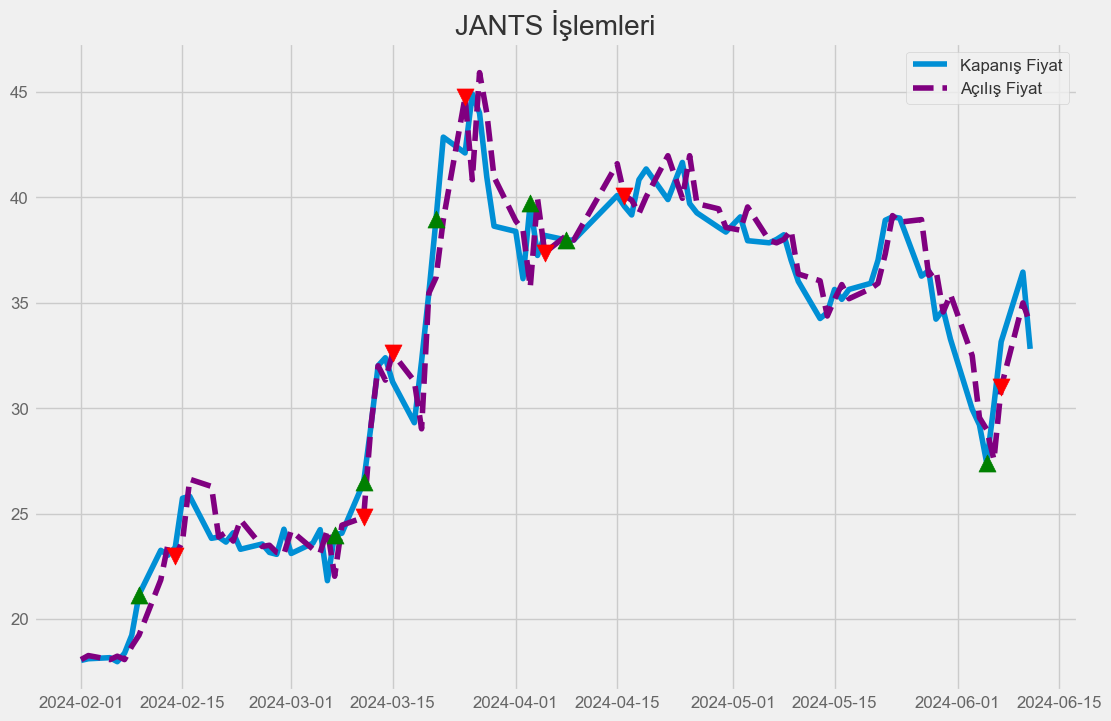

In [ ]:
plt.figure(figsize=(12,8))
plt.title("JANTS İşlemleri")
plt.plot(df[df["Hisse"]=="JANTS.IS"]["Adj Close"].loc["2024-02-01":],label="Kapanış Fiyat")
plt.plot(df[df["Hisse"]=="JANTS.IS"]["Open"].loc["2024-02-01":],"--",color="purple",label="Açılış Fiyat")
for alım in alımlar:
   plt.scatter(x=alım,y=df[df["Hisse"]=="JANTS.IS"].loc[alım]["Adj Close"],marker="^",s=150,color="green",zorder=3)
for satış in satışlar:
   plt.scatter(x=satış,y=df[df["Hisse"]=="JANTS.IS"].loc[satış]["Open"],marker="v",s=150,color="red",zorder=4)
plt.legend()